let us take up the dataset of Cat and Dog Images. The original training dataset on Kaggle has 25000 images of cats and dogs and the test dataset has 10000 unlabelled images.

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-09-12 12:34:47--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.193.128, 173.194.197.128, 64.233.191.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.193.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   192MB/s    in 0.3s    

2021-09-12 12:34:48 (192 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



 import the basic libraries

In [ ]:
import os 
import zipfile 
import tensorflow as tf 
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import matplotlib.pyplot as plt

PREPARING DATASET
create a separate directory for cats that contains only cat images, and a separate director for dogs having only dog images

In [ ]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

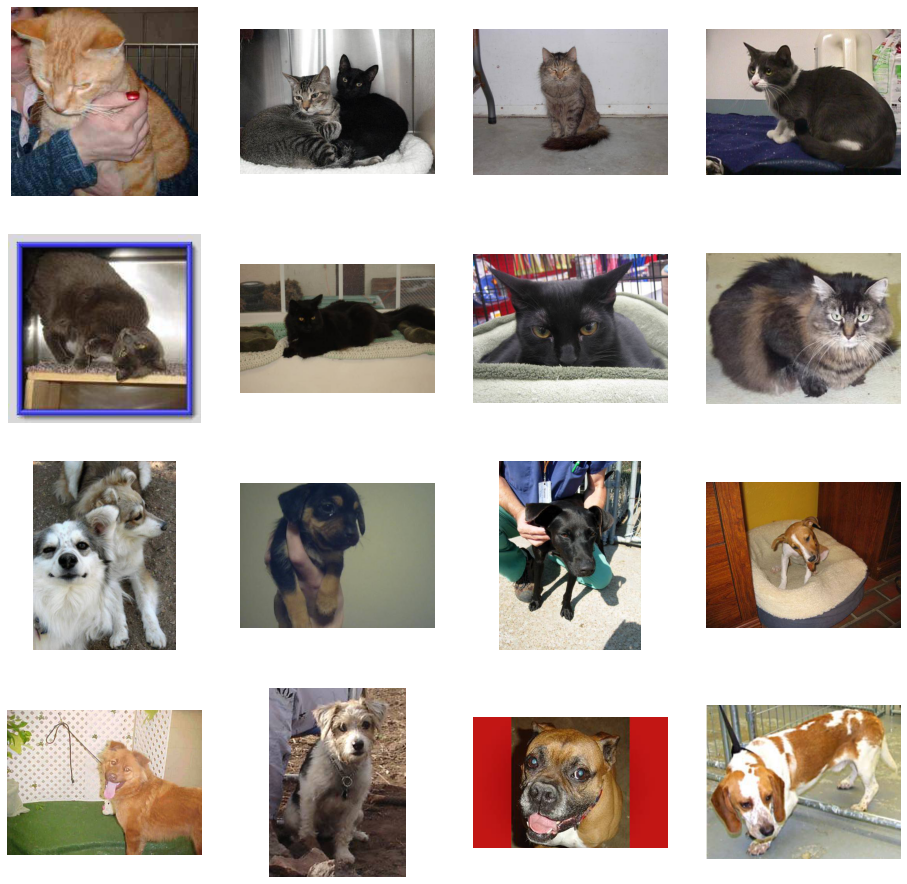

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
# check if the images have been loaded correctly
import matplotlib.image as mpimg
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

we have our dataset ready, let us do it to the model building stage. We will be using 4 different pre-trained models on this dataset.

VGG16

VGG-16 is one of the most popular pre-trained models for image classification. 

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

training and validation

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Loading base model

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58900480/58889256 [==============================] - 2s 0us/step


In [ ]:
#we make some layers non trainable
for layer in base_model.layers:
    layer.trainable = False

Fit the layer

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
100/100 [==============================] - 1511s 15s/step - loss: 0.6699 - acc: 0.6860 - val_loss: 0.3141 - val_acc: 0.8570
Epoch 2/10
100/100 [==============================] - 1509s 15s/step - loss: 0.4783 - acc: 0.7765 - val_loss: 0.2982 - val_acc: 0.8550
Epoch 3/10
100/100 [==============================] - 1510s 15s/step - loss: 0.4263 - acc: 0.8020 - val_loss: 0.2363 - val_acc: 0.8950
Epoch 4/10
100/100 [==============================] - 1506s 15s/step - loss: 0.4152 - acc: 0.8200 - val_loss: 0.2112 - val_acc: 0.9170
Epoch 5/10
100/100 [==============================] - 1506s 15s/step - loss: 0.3939 - acc: 0.8265 - val_loss: 0.2198 - val_acc: 0.9060
Epoch 6/10
100/100 [==============================] - 1507s 15s/step - loss: 0.3569 - acc: 0.8390 - val_loss: 0.2723 - val_acc: 0.8800
Epoch 7/10
100/100 [==============================] - 1506s 15s/step - loss: 0.3391 - acc: 0.8595 - val_loss: 0.1949 - val_acc: 0.9250
Epoch 8/10
100/100 [==============================] - 1

we were able to achieve a validation Accuracy of 92% with just 10 epochs



`
```

Inception dataset  
the Inceptionv3 model we now use for transfer learning
#data augmentation

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2,shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator( rescale = 1.0/255. )

Training and Validation

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))
validation_generator = test_datagen.flow_from_directory(validation_dir, batch_size = 20, class_mode = 'binary', target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


 Loading the Base Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

87924736/87910968 [==============================] - 3s 0us/step


In [ ]:
#change the last layer
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
# fit the model
inc_history = model.fit_generator(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
100/100 [==============================] - 156s 2s/step - loss: 1.0648 - acc: 0.8575 - val_loss: 0.1428 - val_acc: 0.9500
Epoch 2/10
100/100 [==============================] - 151s 2s/step - loss: 0.4397 - acc: 0.8870 - val_loss: 0.1782 - val_acc: 0.9490
Epoch 3/10
100/100 [==============================] - 150s 2s/step - loss: 0.3673 - acc: 0.9095 - val_loss: 0.4776 - val_acc: 0.9150
Epoch 4/10
100/100 [==============================] - 150s 2s/step - loss: 0.3600 - acc: 0.9130 - val_loss: 0.1650 - val_acc: 0.9570
Epoch 5/10
100/100 [==============================] - 150s 2s/step - loss: 0.3409 - acc: 0.9150 - val_loss: 0.1355 - val_acc: 0.9600
Epoch 6/10
100/100 [==============================] - 150s 2s/step - loss: 0.3438 - acc: 0.9230 - val_loss: 0.2030 - val_acc: 0.9480
Epoch 7/10
100/100 [==============================] - 150s 2s/step - loss: 0.3302 - acc: 0.9145 - val_loss: 0.2154 - val_acc: 0.9460
Epoch 8/10
100/100 [==============================] - 150s 2s/step - 

we get 96% Validation accuracy in 10 epochs. Also note, how this model is much faster than VGG16

use ResNet50 on our dataset

In [ ]:
# Add our data-augmentation parameters to ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255., rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

validation_generator = test_datagen.flow_from_directory( validation_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
#Import the base model
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(224, 224,3), include_top=False, weights="imagenet")

basic ResNet model, so we will keep the layers frozen and only modify the last layer

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

compile the model and  try the SGD optimizer

In [ ]:
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.0001),
                   loss = 'binary_crossentropy', metrics = ['acc'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
#Fitting the model
resnet_history = base_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Resnet50 fits much beeter than other pretrained models